# Généralisation robuste de LDA/QDA

Andrew Wang

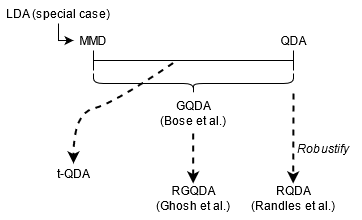

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, S-estimator optimal(selon Croux et al.), etc  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
from plotnine import *
from plotnine.data import *
# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis
from scipy import stats, special, optimize
from sklearn.model_selection import train_test_split
# EMBEDDINGs:
import umap
warnings.filterwarnings('ignore') # AMI warning

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from import_subset_datasets import *
from clustering_accuracy import acc
from vis import *
from dataset_utils import *
from models import *
from fit import *

In [4]:
from _fem import FEM

In [264]:
%run models

<Figure size 432x288 with 0 Axes>

In [265]:
def run_all(X, y, X_test, y_test, slow=True, percent_outliers=0):
    print("LDA")
    ldatest = LDA(method='distributional')#discriminant_analysis.LinearDiscriminantAnalysis()
    ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), ldatest.predict(X_test, percent_outliers))
    print("QDA")
    qdatest = QDA(method='distributional')#discriminant_analysis.QuadraticDiscriminantAnalysis()
    qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qdatest.predict(X_test, percent_outliers))
    print("t-LDA")
    t_ldatest = t_LDA(method='distributional')
    t_ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_ldatest.predict(X_test, percent_outliers))
    print("t-QDA")
    t_qdatest = t_QDA(method='distributional')
    t_qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qdatest.predict(X_test, percent_outliers))
    if not slow:
        return ldatest, qdatest, t_ldatest, t_qdatest
    #print("GQDA")
    #gqdatest = GQDA()
    #gqdatest.fit(X, pd.Series(y))
    #print_metrics(pd.Series(y_test), gqdatest.predict(X_test, percent_outliers))
    """
    print("RGQDA")
    rgqdatest = RGQDA('M-estimator')
    rgqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdatest.predict(X_test, percent_outliers))
    
    print("RGQDA-S")
    rgqdastest = RGQDA('S-estimator')
    rgqdastest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdastest.predict(X_test, percent_outliers))
    print("RQDA-M")
    rqdatest = RGQDA('M-estimator')
    rqdatest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdatest.predict(X_test, percent_outliers))
    print("RQDA-S")
    rqdastest = RGQDA('S-estimator')
    rqdastest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdastest.predict(X_test, percent_outliers))
    """
    print("t-QDA-FEM")
    t_qda_femtest = t_QDA_FEM(method='distributional')
    t_qda_femtest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qda_femtest.predict(X_test, percent_outliers))
    print("QDA-FEM")
    qda_femtest = QDA_FEM(method='distributional')
    qda_femtest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qda_femtest.predict(X_test, percent_outliers))
    
    return {"LDA": ldatest, "QDA": qdatest, "t_LDA": t_ldatest, "t_QDA": t_qdatest, "t_QDA_FEM": t_qda_femtest, "QDA_FEM": qda_femtest} #"RGQDA_M": rgqdatest, "RGQDA_S": rgqdastest, "RQDA_M": rqdatest, "RQDA_S": rqdastest,

In [266]:
def test_all(models, X_test, y_test, percent_outliers=0):
    for model in models:
        print(type(model).__name__)
        print_metrics(pd.Series(y_test), model.predict(X_test, percent_outliers=percent_outliers), conf=False)

In [267]:
def evaluate_all(models, true_means, true_covs):
    labels = [type(model).__name__ for model in models]
    all_estimator_errors = []
    for model in models:
        #print(type(model).__name__)
        all_estimator_errors.append(evaluate_estimators(model, true_means, true_covs))
    all_estimator_errors = np.array(all_estimator_errors)
    fig,(ax1,ax2) = plt.subplots(2,1)
    data_means_errors = {}
    data_covs_errors = {}
    for k in range(len(all_estimator_errors[0,0])):
        data_means_errors[str(k)] = all_estimator_errors[:,0,k]
        data_covs_errors[str(k)] = all_estimator_errors[:,1,k]
    #print(data_means_errors, data_covs_errors, labels)
    bar_plot(ax1, data_means_errors, labels)
    bar_plot(ax2, data_covs_errors, labels)

In [268]:
%run _fem

In [269]:
class FEM_classification(FEM):
    def fit(self, X):
        pass
    def override_params(self, mu, Sigma):
        self.mu_, self.Sigma_ = mu, Sigma
    def _e_step_indicator(self, X):
        return np.ones((X.shape[0], self.K))
    def _e_step(self, X):
        return super()._e_step(X)
    def update_tau(self, X):
        p = X.shape[1]
        tau_new = np.ones((X.shape[0], self.K))
        for k in range(self.K):
            
            diff = X - self.mu_[k]
            tau_new[:, k] = (np.dot(diff, np.linalg.inv(self.Sigma_[k])) * diff).sum(1) / p
            tau_new[:, k] = np.where(tau_new[:, k] < 10**(-12) , 10**(-12),
            np.where(tau_new[:, k] > 10**(12), 10**(12), tau_new[:, k]))
        self.tau_ = tau_new.copy()
    

In [270]:
class FEM_RV(FEM_classification):
    def pdf(self, X):
        cond_prob = self._e_step(X)
        return cond_prob[:, 0] #only care about first k

In [271]:
class LDA_FEM_base():
    def __init__(self):
        self.mean = None
        self.scatter = None
        self.cov = None
        
    def scatter_constant1(self, X):
        return 1/X.shape[1]
    
    def scatter_constant2(self, X):
        diff = X - self.mean
        n = np.trace(self.scatter) / X.shape[1]
        s = self.scatter / n
        maha = (np.dot(diff, np.linalg.inv(s)) * diff).sum(1)
        plt.plot(np.sort(maha)[:195])
        maha_avg = np.median(np.sort(maha)[:math.floor(0.8*len(maha))])
        print("maha avg", maha_avg)
        return maha_avg / n / X.shape[1]
    
    def FEM_estimate(self, X): #X is {X: I(Zi=k|Xi=xi)=1}
        # initialise K=2 (for 1 class, but to maintain structure), tau,alpha randomly and means and sigma with Gaussian MLE
        _K = 2
        FEM_estimator = FEM_classification(_K, rand_initialization=True)
        FEM_estimator._initialize(X)
        FEM_estimator.override_params(np.repeat(X.mean(axis=0)[None,:], _K, axis=0), np.repeat(np.cov(X.T)[None,:], _K, axis=0))
        
        #run E-step to get indicators
        cond_prob = FEM_estimator._e_step_indicator(X)
        #run M-step
        FEM_estimation = FEM_estimator._m_step(X, cond_prob)  
        self.mean = FEM_estimation[1][0,:]; self.scatter = FEM_estimation[2][0,:,:]
        s = self.scatter_constant2(X)
        self.cov = self.scatter * s
        #print("scatter->cov:", s)
        return [self.mean, self.cov]

In [272]:
class LDA_FEM(LDA, LDA_FEM_base):
    def estimate_parameters(self, X):
        return self.FEM_estimate(X)

In [273]:
class QDA_FEM(LDA_FEM, LDA_FEM_base):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False     

In [274]:
class t_LDA_FEM(t_LDA, LDA_FEM_base):
    def estimate_parameters(self, X):
        params = self.FEM_estimate(X)
        return params + [fit_t_dof(X, *params, dof_0=3)]

In [275]:
class t_QDA_FEM(t_LDA_FEM, LDA_FEM_base):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False   

In [276]:
class FEMDA(QDA_FEM):
    def __init__(self, method='distributional'):
        super().__init__(method)
    def _posteriors(self, X):
        print("hello")
        FEM = FEM_classification(self.K, rand_initialization=True)
        FEM._initialize(X)
        FEM.override_params(self.means.T, self.covariances)
        FEM.update_tau(X)
        cond_prob = FEM._e_step(X)
        return cond_prob.T

In [277]:
class FEM_predictor(FEM_classification):
    def __init__(self, K):
        super().__init__(K, rand_initialization=True)
    
    def predict(self, X_new, DA_means, DA_covs):
        assert(self.K == DA_covs.shape[0])
        self._initialize(X_new)
        self.override_params(DA_means.T, DA_covs)

        return super().predict(X_new, thres=0)
        

In [193]:
GN_X = LaplacesDemon.rmvpe(10000, mu=np.array([0,0]), Sigma=np.eye(2), kappa=100)

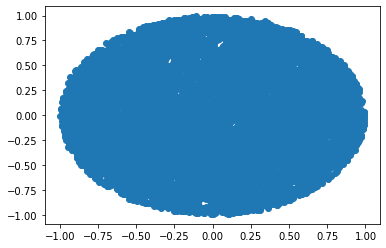

In [194]:
plt.scatter(GN_X[:,0], GN_X[:,1])

In [195]:
print(GN_X.mean(axis=0), np.cov(GN_X.T))

[-0.00355409 -0.00281847] [[0.24551788 0.00203319]
 [0.00203319 0.24863787]]


In [196]:
print(fit_t(GN_X))

(array([-0.00358463, -0.00286752]), array([[0.24488841, 0.00203166],
       [0.00203166, 0.24800387]]), array([270.18340339]))


In [197]:
print(LDA_FEM_base().FEM_estimate(GN_X))

[array([-8.49722751e-07, -1.05015515e-06]), array([[0.98931978, 0.01489019],
       [0.01489019, 1.01068022]])]


## Fashion-MNIST

### Prepare MNIST data

In [43]:
np.random.seed(44)
random.seed(44)

#read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
#read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

read_mnist_train = pd.read_csv(r"data\fashion-mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\fashion-mnist_test.csv")

In [44]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [0,2,3,4,6]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
#mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [45]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [17]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

In [18]:
ret =  lda_grid(em, mapper)
%store ret

Stored 'ret' (tuple)


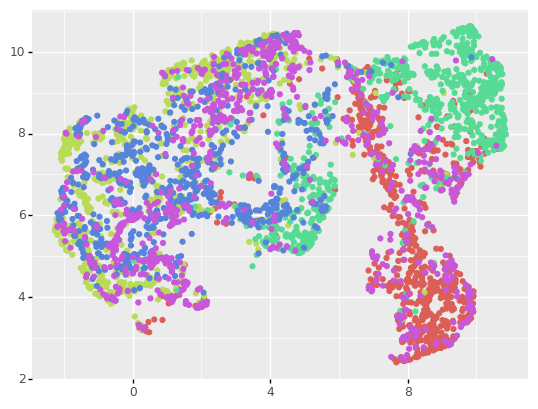

<ggplot: (77034141097)>

In [19]:
gg

### Pure MNIST

In [53]:
models_MNIST_pure = run_all(mnist_pca, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.675 ARI 0.34919 AMI 0.42778
QDA
N 2000 Accuracy 0.487 ARI 0.23571 AMI 0.28763
t-LDA
N 2000 Accuracy 0.7125 ARI 0.4273 AMI 0.44781
t-QDA
N 2000 Accuracy 0.7375 ARI 0.47672 AMI 0.48236
t-QDA-FEM
N 2000 Accuracy 0.7365 ARI 0.47377 AMI 0.4785
QDA-FEM
N 2000 Accuracy 0.729 ARI 0.45888 AMI 0.46887


### MNIST with mislabelling

In [46]:
mnist_labels_mislabelled = mislabelled(800, 0.1, np.unique(mnist_labels))

In [21]:
models_MNIST_mislabelled = run_all(mnist_pca, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.725 ARI 0.45496 AMI 0.46782
QDA
N 2000 Accuracy 0.734 ARI 0.4789 AMI 0.47403
t-LDA
N 2000 Accuracy 0.7135 ARI 0.42887 AMI 0.4487
t-QDA
N 2000 Accuracy 0.742 ARI 0.48683 AMI 0.49033
RGQDA
optimal c is 0.9570321388596548
N 2000 Accuracy 0.7255 ARI 0.46184 AMI 0.4665
RGQDA-S
optimal c is 0.7705327988859793
N 2000 Accuracy 0.7145 ARI 0.43782 AMI 0.45336
RQDA-M
N 2000 Accuracy 0.7245 ARI 0.46114 AMI 0.46725
RQDA-S
N 2000 Accuracy 0.706 ARI 0.4276 AMI 0.44605
t-QDA-FEM
N 1461 Accuracy 0.79261 ARI 0.56971 AMI 0.56705
QDA-FEM
N 598 Accuracy 0.54181 ARI 0.0 AMI -0.0


### MNIST with contamination

In [47]:
mnist_pca_contaminated,_ = contaminate_dataset(mnist_pca, 0.1)

In [23]:
models_MNIST_contaminated = run_all(mnist_pca_contaminated, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.675 ARI 0.35444 AMI 0.41888
QDA
N 2000 Accuracy 0.511 ARI 0.26734 AMI 0.31593
t-LDA
N 2000 Accuracy 0.7145 ARI 0.43153 AMI 0.45156
t-QDA
N 2000 Accuracy 0.738 ARI 0.47717 AMI 0.48203
RGQDA
optimal c is 0.994049198590175
N 2000 Accuracy 0.726 ARI 0.46112 AMI 0.4669
RGQDA-S
optimal c is 0.7334635446685435
N 2000 Accuracy 0.715 ARI 0.44054 AMI 0.45711
RQDA-M
N 2000 Accuracy 0.726 ARI 0.46112 AMI 0.4669
RQDA-S
N 2000 Accuracy 0.707 ARI 0.43125 AMI 0.45079
t-QDA-FEM
N 1419 Accuracy 0.80268 ARI 0.58341 AMI 0.58075
QDA-FEM
N 598 Accuracy 0.54181 ARI 0.0 AMI -0.0


### MNIST with contamination and mislabelling

LDA
0.07812356948852539
N 2000 Accuracy 0.695 ARI 0.3912 AMI 0.43658
QDA
0.0
N 2000 Accuracy 0.4855 ARI 0.21257 AMI 0.25746
t-LDA
5.640101194381714
N 2000 Accuracy 0.693 ARI 0.40094 AMI 0.40407
t-QDA
3.255096912384033
N 2000 Accuracy 0.7285 ARI 0.46564 AMI 0.47149
t-QDA-FEM
maha avg 2053588.5344069158
maha avg 2392678.062474139
maha avg 1642766.1596197176
maha avg 2036882.4318491518
maha avg 2597825.1156736747
0.4388844966888428
N 2000 Accuracy 0.727 ARI 0.46295 AMI 0.46938
QDA-FEM
maha avg 2053588.5344069158
maha avg 2392678.062474139
maha avg 1642766.1596197176
maha avg 2036882.4318491518
maha avg 2597825.1156736747
0.3164212703704834
N 2000 Accuracy 0.6705 ARI 0.36253 AMI 0.38062


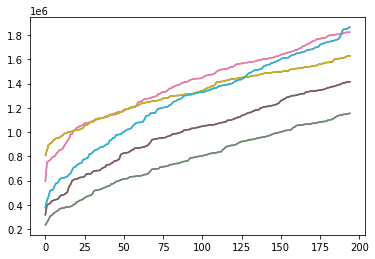

In [278]:
models_MNIST_contaminated_mislabelled = run_all(mnist_pca_contaminated, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

In [250]:
mnist_pca_n = normalise_centered(mnist_pca_contaminated, mnist_labels_mislabelled)
mnist_test_pca_n = normalise_centered(mnist_test_pca, mnist_test_labels)

Without outlier rejection
LDA
N 2000 Accuracy 0.2 ARI 0.0 AMI -0.0
QDA
N 2000 Accuracy 0.2 ARI 0.0 AMI -0.0
t-LDA
N 2000 Accuracy 1.0 ARI 1.0 AMI 1.0
t-QDA
N 2000 Accuracy 1.0 ARI 1.0 AMI 1.0
t-QDA-FEM
maha avg 1.1732647236200573
maha avg 1.0642404032837836
maha avg 1.0460439023473995
maha avg 1.0590288305985074
maha avg 1.1452647813931804
N 2000 Accuracy 1.0 ARI 1.0 AMI 1.0
QDA-FEM
maha avg 1.1732647236200573
maha avg 1.0642404032837836
maha avg 1.0460439023473995
maha avg 1.0590288305985074
maha avg 1.1452647813931804
N 2000 Accuracy 0.2 ARI 0.0 AMI -0.0


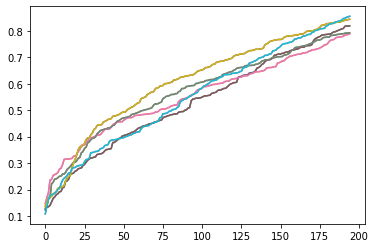

In [251]:
print("Without outlier rejection")
models_MNIST_n = run_all(mnist_pca_n,mnist_labels_mislabelled,mnist_test_pca_n,mnist_test_labels, percent_outliers=0)

### MNIST contaminated test labels

In [252]:
mnist_test_pca_c, contam_ind = contaminate_dataset(mnist_test_pca, 0.1)
test_all(models_MNIST_contaminated_mislabelled, mnist_test_pca_c, apply_outlierness(contam_ind, mnist_test_labels), percent_outliers=0.1)

LDA
N 2000 Accuracy 0.7045 ARI 0.40956 AMI 0.47702
QDA
N 2000 Accuracy 0.496 ARI 0.24837 AMI 0.35056
t_LDA
N 2000 Accuracy 0.691 ARI 0.40762 AMI 0.44279
t_QDA
N 2000 Accuracy 0.753 ARI 0.50784 AMI 0.55602
t_QDA_FEM
N 2000 Accuracy 0.7505 ARI 0.50428 AMI 0.55382
QDA_FEM
N 2000 Accuracy 0.6475 ARI 0.38547 AMI 0.4304


In [253]:
mnist_test_pca_c_n = normalise_centered(mnist_test_pca_c, apply_outlierness(contam_ind, mnist_test_labels))

In [255]:
test_all(list(models_MNIST_n.values()), mnist_test_pca_c_n, apply_outlierness(contam_ind, mnist_test_labels), percent_outliers=0.1)


LDA
N 2000 Accuracy 0.284 ARI 0.08706 AMI 0.309
QDA
N 2000 Accuracy 0.284 ARI 0.08706 AMI 0.309
t_LDA
N 2000 Accuracy 0.874 ARI 0.78996 AMI 0.82963
t_QDA
N 2000 Accuracy 0.874 ARI 0.78996 AMI 0.82963
t_QDA_FEM
N 2000 Accuracy 0.874 ARI 0.78996 AMI 0.82963
QDA_FEM
N 2000 Accuracy 0.284 ARI 0.08706 AMI 0.309


## Sklearn discriminant analysis

### Sklearn LDA

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

In [ ]:
plot_contours_UMAP(gg, lda, *ret)

In [ ]:
plot_regions_UMAP(gg, lda, *ret)

### Sklearn QDA

In [ ]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

## Synthetic Data setup 1

In [14]:
np.random.seed(seed=233423)

In [15]:
means_synth1 = {0: [1, 1, 1, 1, 1, 1 ], 1: [-1,-1,-1, 1, 1, 1], 2: [1, 1, 1, -1,-1,-1], 3: [-1,-1,-1,-1,-1,-1]}
covs_synth1 = {0: np.eye(6), 1: np.eye(6), 2: np.eye(6), 3: np.eye(6)}

In [16]:
def synthesise(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[0], shape=covs_synth1[0], df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[1], shape=covs_synth1[1], df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[2], shape=covs_synth1[2], df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[3], shape=covs_synth1[3], df=1, hard=hard) #cauchy
    y =  mislabelled(n, mislabelling, np.arange(4))
    return np.vstack([X1, X2, X3, X4]), y, apply_outlierness([o1,o2,o3,o4],y)

In [17]:
X_test,_,y_test = synthesise(1000)

### Synthetic data pure

In [18]:
X,y,_ = synthesise(1000, contamination=0, mislabelling=0)

In [19]:
models_synth_pure = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.6475 ARI 0.31567 AMI 0.33083
QDA
N 4000 Accuracy 0.54575 ARI 0.28166 AMI 0.32733
t-LDA
N 4000 Accuracy 0.82875 ARI 0.60506 AMI 0.56191
t-QDA
N 4000 Accuracy 0.82775 ARI 0.60295 AMI 0.55957
t-QDA-FEM
N 4000 Accuracy 0.8275 ARI 0.60179 AMI 0.55889
QDA-FEM
N 4000 Accuracy 0.81525 ARI 0.57076 AMI 0.54864


### Synthetic data with mislabelling

In [34]:
X,y ,_= synthesise(1000, contamination=0, mislabelling=0.1)

In [35]:
models_synth_mislabelling = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.6145 ARI 0.30706 AMI 0.32768
QDA
N 4000 Accuracy 0.51625 ARI 0.22649 AMI 0.25811
t-LDA
N 4000 Accuracy 0.82525 ARI 0.59835 AMI 0.55427
t-QDA
N 4000 Accuracy 0.82425 ARI 0.59678 AMI 0.55337
RGQDA
optimal c is 0.8639761597814077
N 4000 Accuracy 0.80125 ARI 0.54673 AMI 0.51493
t-QDA-FEM
N 4000 Accuracy 0.82325 ARI 0.59417 AMI 0.54959
QDA-FEM
N 4000 Accuracy 0.79675 ARI 0.54018 AMI 0.50087


### Synthetic data with contamination

In [36]:
X,y,_ = synthesise(1000, contamination=0.1, mislabelling=0)

In [37]:
models_synth_contamination = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.68575 ARI 0.36415 AMI 0.36998
QDA
N 4000 Accuracy 0.537 ARI 0.26766 AMI 0.31057
t-LDA
N 4000 Accuracy 0.8235 ARI 0.59509 AMI 0.55114
t-QDA
N 4000 Accuracy 0.82275 ARI 0.59295 AMI 0.54811
RGQDA
optimal c is 0.9817449640917932
N 4000 Accuracy 0.8095 ARI 0.56471 AMI 0.52928
t-QDA-FEM
N 4000 Accuracy 0.82425 ARI 0.59574 AMI 0.55078
QDA-FEM
N 4000 Accuracy 0.79375 ARI 0.53445 AMI 0.49649


### Synthetic data with contamination and mislabelling

In [18]:
X,y,_ = synthesise(1000, contamination=0.1, mislabelling=0.1)

In [97]:
models_synth_contamination_mislabelling = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.75575 ARI 0.46422 AMI 0.43513
QDA
N 4000 Accuracy 0.4615 ARI 0.13462 AMI 0.19552
t-LDA
N 4000 Accuracy 0.8225 ARI 0.59212 AMI 0.54639
t-QDA
N 4000 Accuracy 0.82 ARI 0.58753 AMI 0.54282
t-QDA-FEM
maha avg 10.512301198403566
scatter->cov: 0.004473542953246912
maha avg 6.080280653821367
scatter->cov: 0.16842573446322737
maha avg 5.429281334748348
scatter->cov: 0.14591385549908864
maha avg 9.185084133811813
scatter->cov: 0.007059421995031262
N 4000 Accuracy 0.82175 ARI 0.59038 AMI 0.54705
QDA-FEM
maha avg 10.512301198403566
scatter->cov: 0.004473542953246912
maha avg 6.080280653821367
scatter->cov: 0.16842573446322737
maha avg 5.429281334748348
scatter->cov: 0.14591385549908864
maha avg 9.185084133811813
scatter->cov: 0.007059421995031262
N 4000 Accuracy 0.80375 ARI 0.54883 AMI 0.52971


In [98]:
for c in models_synth_contamination_mislabelling["t_QDA"].covariances:
    print(np.trace(c))

7.6584808301425475
6.845840549480597
6.466543603374587
7.260353458739165


[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.94303123  0.89359795  0.90697561  0.99843001  1.00409317  0.95435806]
 [-0.86325976 -0.93436822 -0.94688627  0.9635432   0.98018682  0.89754478]
 [ 0.98378732  0.96497715  0.88047828 -0.93083858 -0.94107024 -0.98075406]
 [-0.94111601 -0.97120758 -0.94036671 -0.94354306 -0.98320982 -1.02220899]]
[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.94303123  0.89359795  0.90697561  0.99843001  1.00409317  0.95435806]
 [-0.86325976 -0.93436822 -0.94688627  0.9635432   0.98018682  0.89754478]
 [ 0.98378732  0.96497715  0.88047828 -0.93083858 -0.94107024 -0.98075406]
 [-0.94111601 -0.97120758 -0.94036671 -0.94354306 -0.98320982 -1.02220899]]
[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.90363774  0.91316537  0.90371012  1.01135412  1.01256611  0.97266691]
 [-0.8793607  -0.98192088 -0.94161267  1.005

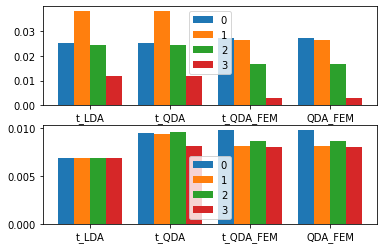

In [20]:
evaluate_all(models_synth_contamination_mislabelling[2:], means_synth1, covs_synth1)

### Synthetic data with test contamination

In [21]:
X_test_c,y_test_c_clean,y_test_c = synthesise(1000, contamination=0.1, mislabelling=0)

In [22]:
print("With outlier rejection")
test_all(models_synth_contamination_mislabelling,X_test_c,y_test_c, percent_outliers=0.1)

With outlier rejection
LDA
N 4000 Accuracy 0.7255 ARI 0.42193 AMI 0.38641
QDA
N 4000 Accuracy 0.45525 ARI 0.12975 AMI 0.1762
t_LDA
N 4000 Accuracy 0.78425 ARI 0.51801 AMI 0.4633
t_QDA
N 4000 Accuracy 0.785 ARI 0.51579 AMI 0.46282
t_QDA_FEM
N 4000 Accuracy 0.783 ARI 0.51095 AMI 0.46139
QDA_FEM
N 4000 Accuracy 0.746 ARI 0.43493 AMI 0.41974


[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.94303123  0.89359795  0.90697561  0.99843001  1.00409317  0.95435806]
 [-0.86325976 -0.93436822 -0.94688627  0.9635432   0.98018682  0.89754478]
 [ 0.98378732  0.96497715  0.88047828 -0.93083858 -0.94107024 -0.98075406]
 [-0.94111601 -0.97120758 -0.94036671 -0.94354306 -0.98320982 -1.02220899]]
[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.94303123  0.89359795  0.90697561  0.99843001  1.00409317  0.95435806]
 [-0.86325976 -0.93436822 -0.94688627  0.9635432   0.98018682  0.89754478]
 [ 0.98378732  0.96497715  0.88047828 -0.93083858 -0.94107024 -0.98075406]
 [-0.94111601 -0.97120758 -0.94036671 -0.94354306 -0.98320982 -1.02220899]]
[[1, 1, 1, 1, 1, 1], [-1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1], [-1, -1, -1, -1, -1, -1]] [[ 0.90363774  0.91316537  0.90371012  1.01135412  1.01256611  0.97266691]
 [-0.8793607  -0.98192088 -0.94161267  1.005

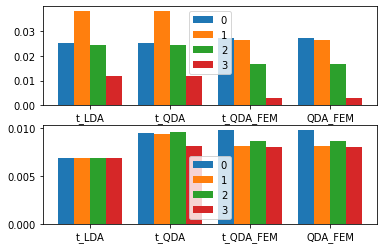

In [24]:
evaluate_all(models_synth_contamination_mislabelling[2:], means_synth1, covs_synth1)

In [25]:
print("Without outlier rejection")
test_all(models_synth_contamination_mislabelling,X_test_c,y_test_c_clean, percent_outliers=0)

Without outlier rejection
LDA
N 4000 Accuracy 0.7375 ARI 0.4289 AMI 0.39711
QDA
N 4000 Accuracy 0.44975 ARI 0.12136 AMI 0.17981
t_LDA
N 4000 Accuracy 0.80475 ARI 0.55358 AMI 0.50787
t_QDA
N 4000 Accuracy 0.8055 ARI 0.55436 AMI 0.50927
t_QDA_FEM
N 4000 Accuracy 0.805 ARI 0.55244 AMI 0.51046
QDA_FEM
N 4000 Accuracy 0.78025 ARI 0.49489 AMI 0.49058


### Normalised data with test contamination

In [45]:
X_n = normalise(X)
X_test_c_n = normalise(X_test_c)

In [46]:
print("With outlier rejection")
models_synth_mislabelling_contamination_n = run_all(X_n,y,X_test_c_n,y_test_c, percent_outliers=0.1)

With outlier rejection
LDA
N 4000 Accuracy 0.755 ARI 0.47498 AMI 0.42208
QDA
N 4000 Accuracy 0.75 ARI 0.46446 AMI 0.41265
t-LDA
N 4000 Accuracy 0.75575 ARI 0.47517 AMI 0.42202
t-QDA
N 4000 Accuracy 0.7495 ARI 0.46129 AMI 0.40992
RGQDA
optimal c is 0.2383399961532713
N 4000 Accuracy 0.74 ARI 0.43685 AMI 0.39819
t-QDA-FEM
N 4000 Accuracy 0.7515 ARI 0.46892 AMI 0.41737
QDA-FEM
N 4000 Accuracy 0.74825 ARI 0.46613 AMI 0.416


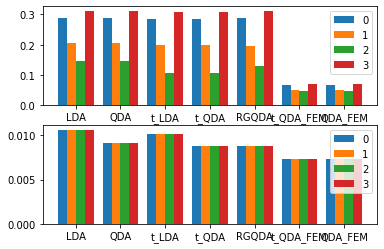

In [101]:
evaluate_all(models_synth_mislabelling_contamination_n[0:], normalise(means_synth1).T, covs_synth1)

In [48]:
print("Without outlier rejection")
test_all(models_synth_mislabelling_contamination_n,X_test_c_n,y_test_c_clean, percent_outliers=0)

Without outlier rejection
LDA
N 4000 Accuracy 0.78175 ARI 0.50995 AMI 0.47294
QDA
N 4000 Accuracy 0.7765 ARI 0.49959 AMI 0.46413
t_LDA
N 4000 Accuracy 0.783 ARI 0.51177 AMI 0.47417
t_QDA
N 4000 Accuracy 0.7755 ARI 0.49695 AMI 0.46214
RGQDA
N 4000 Accuracy 0.76825 ARI 0.47746 AMI 0.45476
t_QDA_FEM
N 4000 Accuracy 0.77875 ARI 0.5039 AMI 0.46766
QDA_FEM
N 4000 Accuracy 0.7755 ARI 0.49901 AMI 0.46453


## Synthetic data setup 2 (for visualisation)

In [49]:
means_synth2 = np.array([np.array([2 , 2]), np.array([-2, 2]), np.array([2 ,-2]), np.array([-2,-2]), np.array([2 , 6])]) 
covs_synth2 = np.array([np.eye(2), np.eye(2), np.eye(2), np.eye(2), np.eye(2)])

In [50]:
def synthesise2d(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[0], shape=covs_synth2[0], df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[1], shape=covs_synth2[1], df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[2], shape=covs_synth2[2], df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[3], shape=covs_synth2[3], df=1, hard=hard) #cauchy
    X5,o5 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[4], shape=covs_synth2[4], df=1, hard=hard) #cauchy
    y = mislabelled(n, mislabelling, np.arange(5))
    return np.vstack([X1, X2, X3, X4, X5]), y, apply_outlierness([o1,o2,o3,o4,o5], y)

In [51]:
X_test_2d,_,y_test_2d = synthesise2d(100)

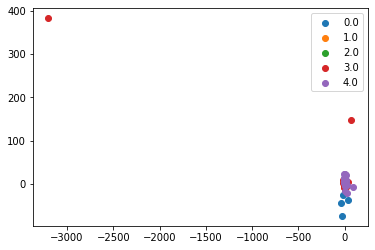

In [52]:
ax = plt.figure().gca()
#plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)
plt.legend()

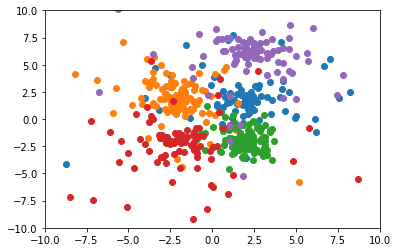

In [53]:
ax = plt.figure().gca()
plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)

### Pure dataset

In [54]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0, mislabelling=0)

In [55]:
models_vis_pure = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.732 ARI 0.4532 AMI 0.45529
QDA
N 500 Accuracy 0.656 ARI 0.4287 AMI 0.43399
t-LDA
N 500 Accuracy 0.804 ARI 0.57831 AMI 0.55477
t-QDA
N 500 Accuracy 0.81 ARI 0.58722 AMI 0.56245
RGQDA
optimal c is 0.0
N 500 Accuracy 0.752 ARI 0.46767 AMI 0.50383
t-QDA-FEM
N 500 Accuracy 0.814 ARI 0.59514 AMI 0.56763
QDA-FEM
N 500 Accuracy 0.812 ARI 0.58948 AMI 0.57207


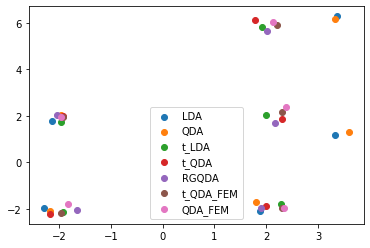

In [56]:
plot_means(models_vis_pure)

In [57]:
approx_tQDA_test_pure = t_QDA(method='generalised')
approx_tQDA_test_pure.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_pure.predict(X_test_2d))

N 500 Accuracy 0.744 ARI 0.45445 AMI 0.49198


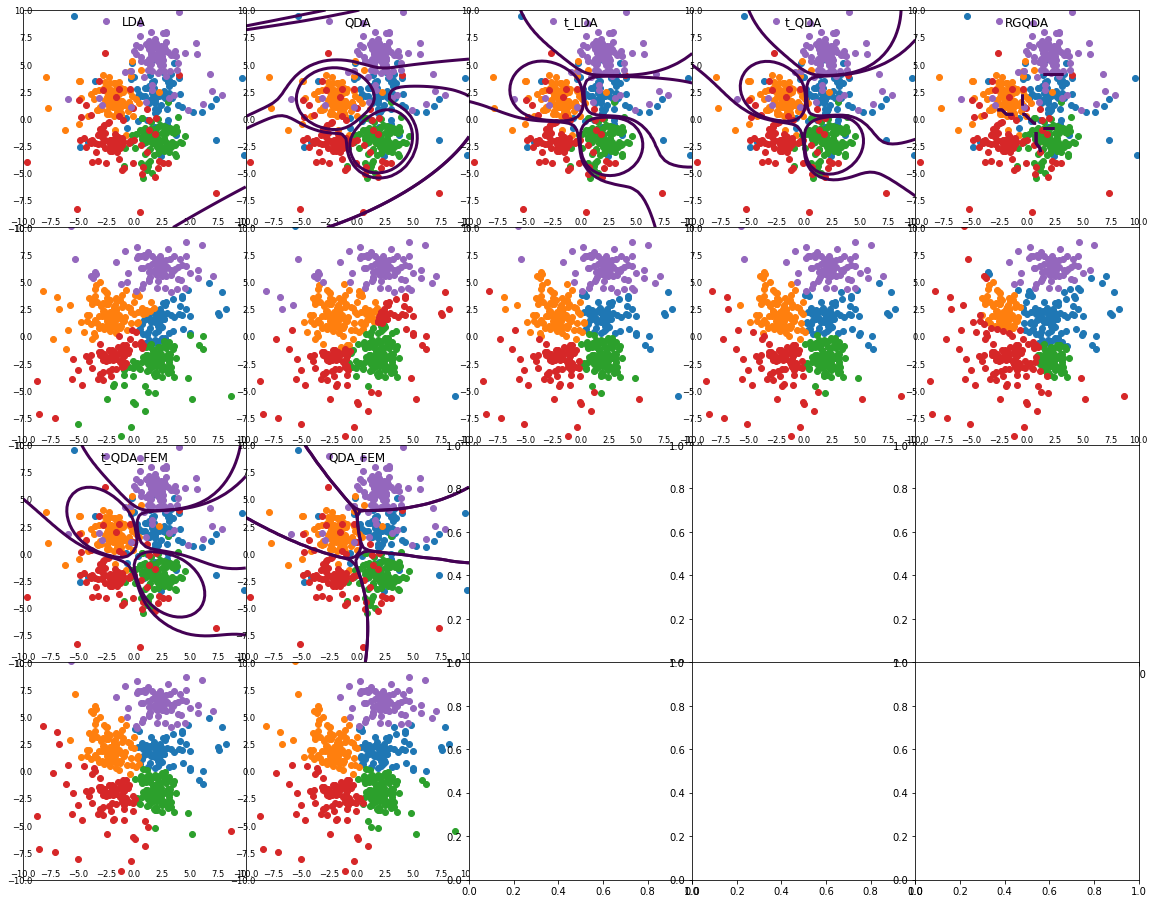

In [58]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_pure)#+(approx_tQDA_test_pure,))

### Dataset with mislabelling

In [59]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0, mislabelling=0.1)

In [60]:
models_vis_mislabelling = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.688 ARI 0.40707 AMI 0.43199
QDA
N 500 Accuracy 0.56 ARI 0.3337 AMI 0.38125
t-LDA
N 500 Accuracy 0.804 ARI 0.57725 AMI 0.55208
t-QDA
N 500 Accuracy 0.806 ARI 0.58037 AMI 0.55165
RGQDA
optimal c is 0.0
N 500 Accuracy 0.762 ARI 0.48949 AMI 0.50927
t-QDA-FEM
N 500 Accuracy 0.79 ARI 0.55316 AMI 0.52914
QDA-FEM
N 500 Accuracy 0.786 ARI 0.54165 AMI 0.52167


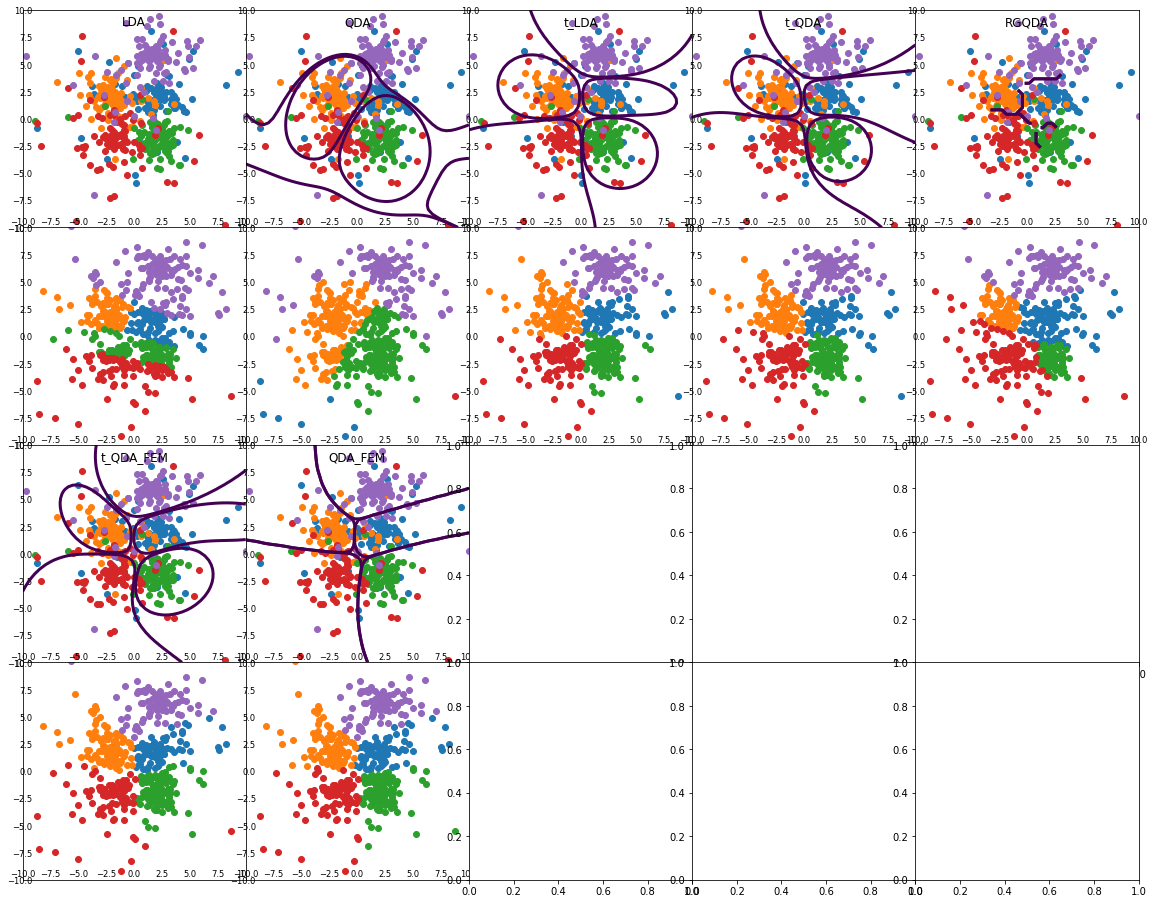

In [61]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling)#+(approx_tQDA_test_mislabelling,))

### Dataset with contamination

In [62]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0.1, mislabelling=0)

In [63]:
models_vis_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.754 ARI 0.48996 AMI 0.49998
QDA
N 500 Accuracy 0.584 ARI 0.35937 AMI 0.41339
t-LDA
N 500 Accuracy 0.79 ARI 0.5533 AMI 0.53128
t-QDA
N 500 Accuracy 0.796 ARI 0.56138 AMI 0.53659
RGQDA
optimal c is 0.8993598007160752
N 500 Accuracy 0.792 ARI 0.55318 AMI 0.53081
t-QDA-FEM
N 500 Accuracy 0.796 ARI 0.56247 AMI 0.542
QDA-FEM
N 500 Accuracy 0.792 ARI 0.5527 AMI 0.55071


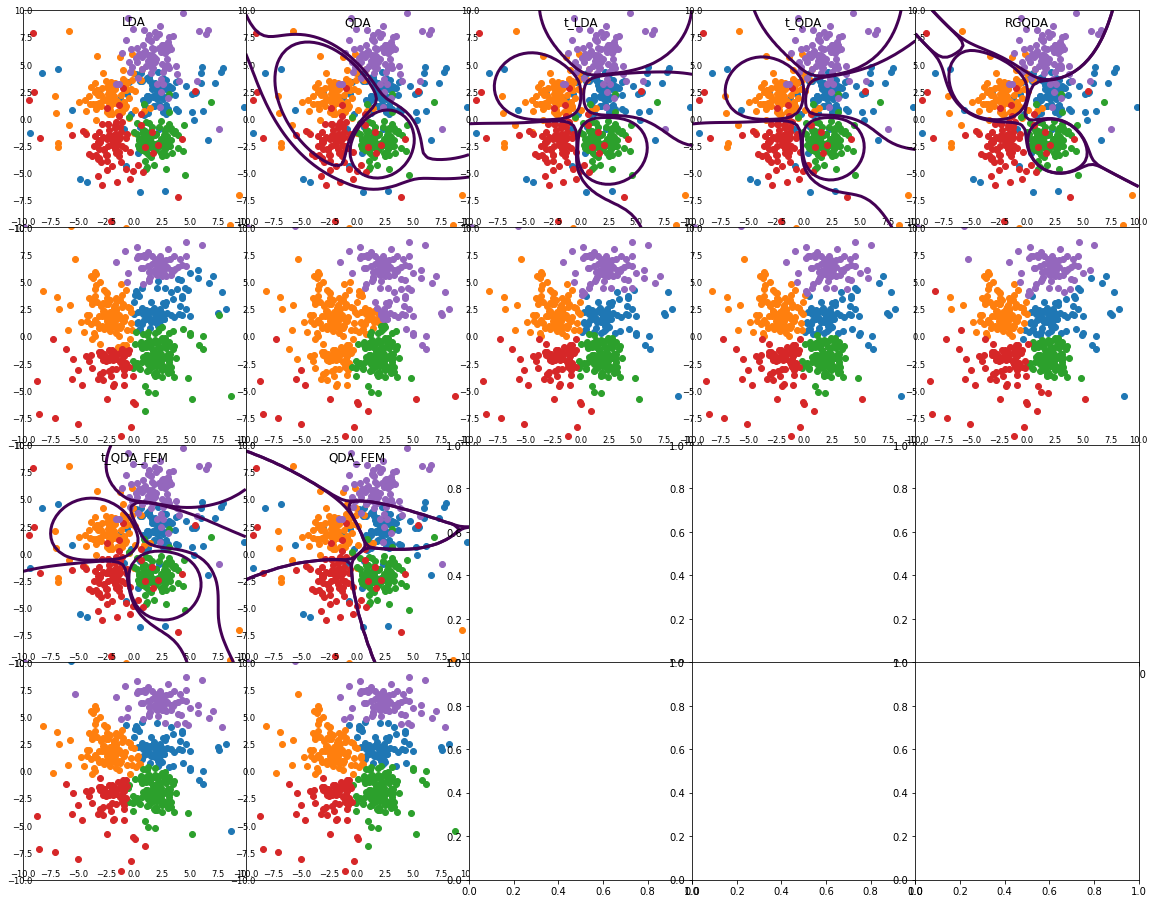

In [64]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_contamination)#+(approx_tQDA_test_contamination,))

### Dataset with mislabelling and contamination

In [65]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0.1, mislabelling=0.1)

In [66]:
models_vis_mislabelling_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.786 ARI 0.53812 AMI 0.52634
QDA
N 500 Accuracy 0.47 ARI 0.21635 AMI 0.26831
t-LDA
N 500 Accuracy 0.81 ARI 0.58636 AMI 0.55875
t-QDA
N 500 Accuracy 0.806 ARI 0.5794 AMI 0.54741
RGQDA
optimal c is 0.3516225486251208
N 500 Accuracy 0.8 ARI 0.56527 AMI 0.54829
t-QDA-FEM
N 500 Accuracy 0.798 ARI 0.56357 AMI 0.53481
QDA-FEM
N 500 Accuracy 0.796 ARI 0.55808 AMI 0.54504


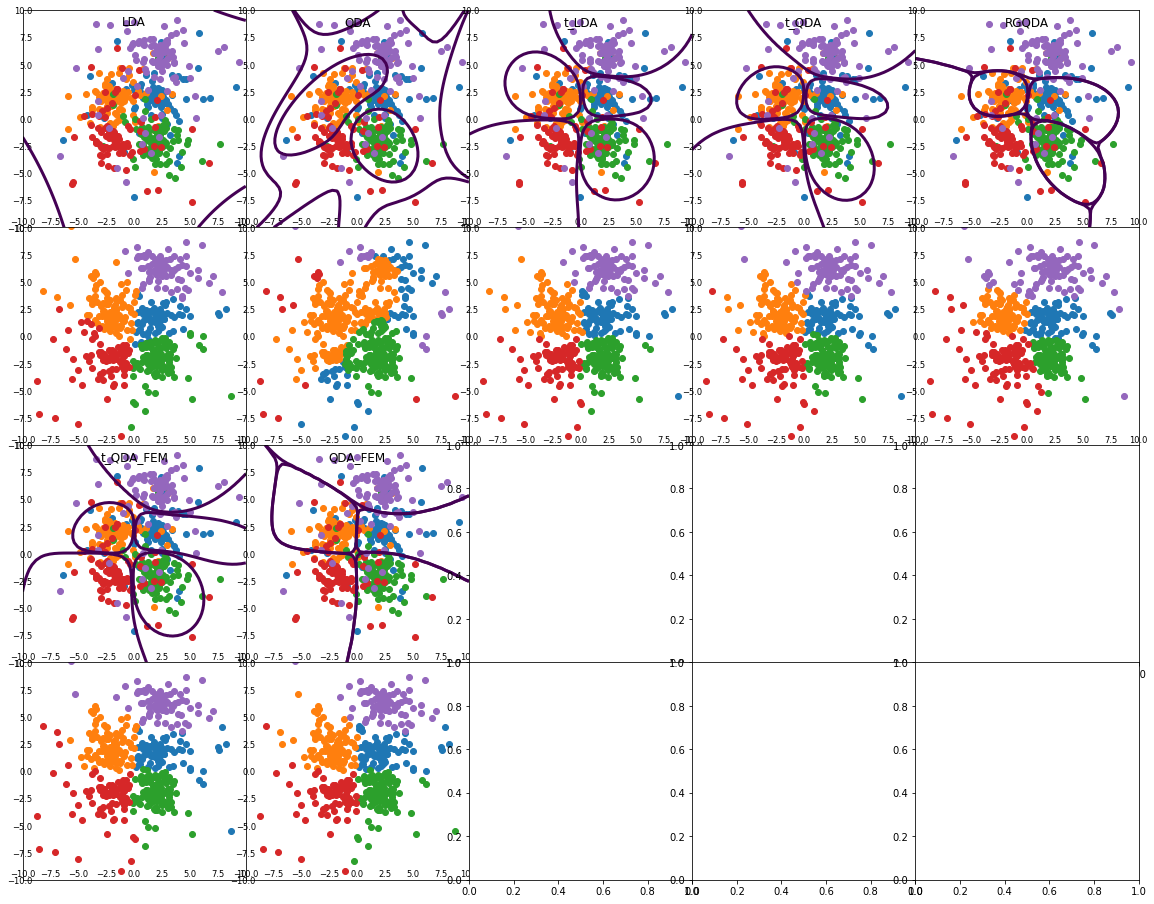

In [67]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling_contamination)#+(approx_tQDA_test_mislabelling_contamination,))

### Dataset with test contamination

In [68]:
X_test_c_2d,y_test_c_2d_clean,y_test_c_2d = synthesise2d(100, contamination=0.1)

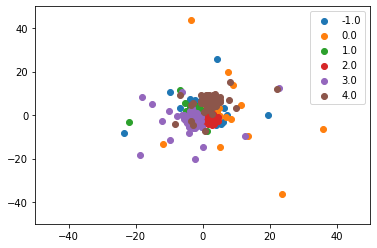

In [69]:
ax = plt.figure().gca()
plt.xlim([-50,50]); plt.ylim([-50,50])
plot_dataset(X_test_c_2d, y_test_c_2d, ax)
plt.legend()

In [70]:
print("With outlier rejection")
test_all(models_vis_mislabelling_contamination,X_test_c_2d,y_test_c_2d, percent_outliers=0.1)

With outlier rejection
LDA
N 500 Accuracy 0.74 ARI 0.5168 AMI 0.50217
QDA
N 500 Accuracy 0.454 ARI 0.21748 AMI 0.27129
t_LDA
N 500 Accuracy 0.776 ARI 0.56244 AMI 0.54743
t_QDA
N 500 Accuracy 0.766 ARI 0.53966 AMI 0.5211
RGQDA
N 500 Accuracy 0.74 ARI 0.50488 AMI 0.49896
t_QDA_FEM
N 500 Accuracy 0.768 ARI 0.55112 AMI 0.53326
QDA_FEM
N 500 Accuracy 0.768 ARI 0.55298 AMI 0.54096


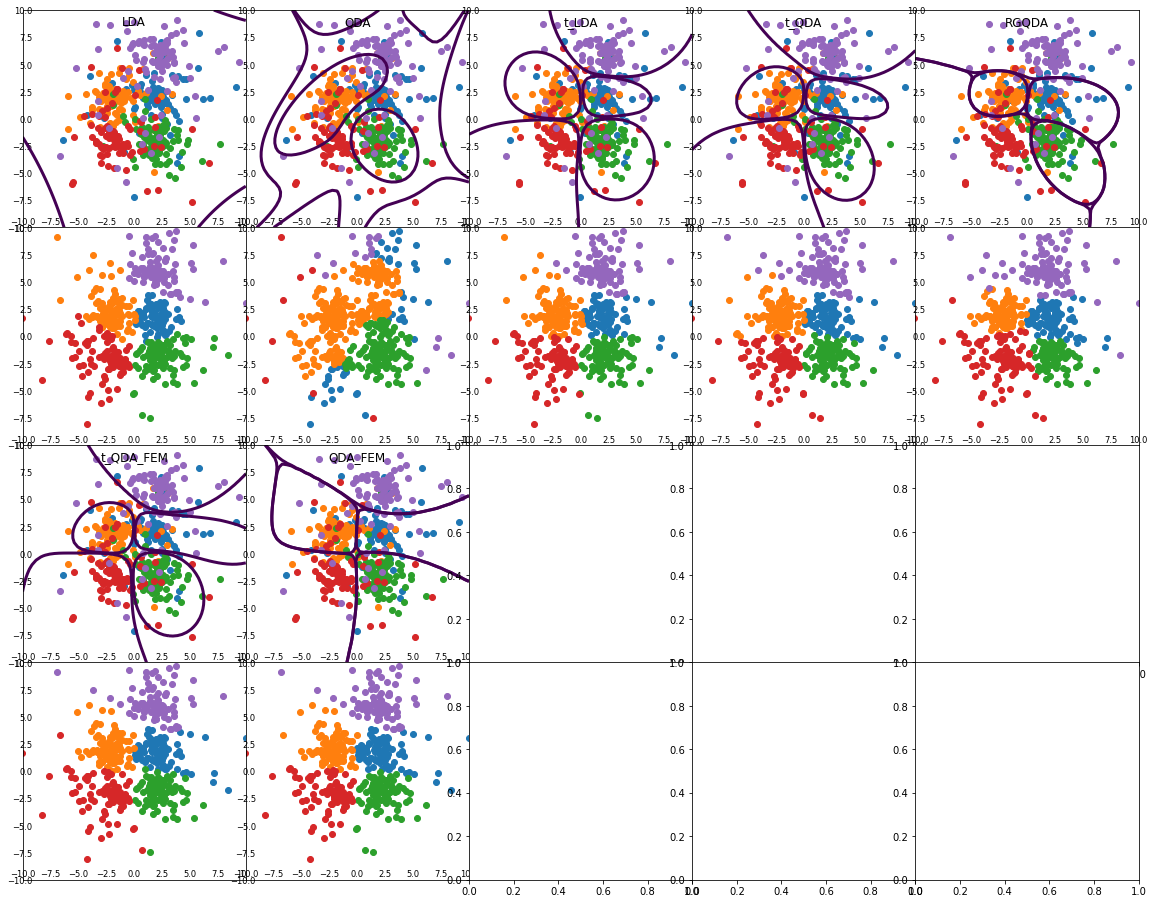

In [71]:
plot_models(X_2d, y_2d, X_test_c_2d, models_vis_mislabelling_contamination)

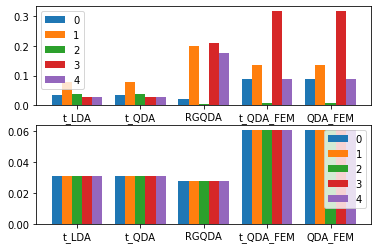

In [72]:
evaluate_all(models_vis_mislabelling_contamination[2:], means_synth2.T, covs_synth2)

In [73]:
print("Without outlier rejection")
test_all(models_vis_mislabelling_contamination,X_test_c_2d,y_test_c_2d_clean, percent_outliers=0)

Without outlier rejection
LDA
N 500 Accuracy 0.786 ARI 0.55344 AMI 0.54556
QDA
N 500 Accuracy 0.472 ARI 0.22369 AMI 0.30293
t_LDA
N 500 Accuracy 0.818 ARI 0.603 AMI 0.57968
t_QDA
N 500 Accuracy 0.826 ARI 0.62056 AMI 0.6092
RGQDA
N 500 Accuracy 0.806 ARI 0.5798 AMI 0.58463
t_QDA_FEM
N 500 Accuracy 0.828 ARI 0.62227 AMI 0.60609
QDA_FEM
N 500 Accuracy 0.814 ARI 0.59319 AMI 0.57283


### Normalised dataset with test contamination

In [74]:
X_2d_n = normalise(X_2d)
X_test_c_2d_n = normalise(X_test_c_2d)

In [75]:
print("With outlier rejection")
models_vis_mislabelling_contamination_n = run_all(X_2d_n,y_2d,X_test_c_2d_n,y_test_c_2d, percent_outliers=0.1)

With outlier rejection
LDA
N 500 Accuracy 0.692 ARI 0.4579 AMI 0.44732
QDA
N 500 Accuracy 0.694 ARI 0.46146 AMI 0.4498
t-LDA
N 500 Accuracy 0.676 ARI 0.44488 AMI 0.43766
t-QDA
N 500 Accuracy 0.688 ARI 0.45308 AMI 0.44504
RGQDA
optimal c is 0.0
N 500 Accuracy 0.67 ARI 0.42718 AMI 0.43063
t-QDA-FEM
N 500 Accuracy 0.68 ARI 0.4528 AMI 0.44936
QDA-FEM
N 500 Accuracy 0.662 ARI 0.44927 AMI 0.44987


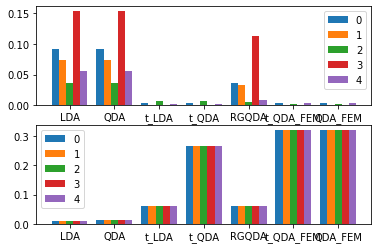

In [102]:
evaluate_all(models_vis_mislabelling_contamination_n[0:], normalise(means_synth2).T, covs_synth2)

In [77]:
print("Without outlier rejection")
test_all(models_vis_mislabelling_contamination_n,X_test_c_2d_n,y_test_c_2d_clean, percent_outliers=0)

Without outlier rejection
LDA
N 500 Accuracy 0.76 ARI 0.52465 AMI 0.52524
QDA
N 500 Accuracy 0.756 ARI 0.52093 AMI 0.52147
t_LDA
N 500 Accuracy 0.762 ARI 0.52414 AMI 0.52365
t_QDA
N 500 Accuracy 0.766 ARI 0.5293 AMI 0.52928
RGQDA
N 500 Accuracy 0.744 ARI 0.48861 AMI 0.50274
t_QDA_FEM
N 500 Accuracy 0.752 ARI 0.52074 AMI 0.52878
QDA_FEM
N 500 Accuracy 0.736 ARI 0.51442 AMI 0.5279


## Synthetic data setup 3

In [236]:
p=2
means_synth3 = {2: np.zeros((p)), 0: -10*np.ones((p)), 1: 10*np.ones((p))}
covs_synth3 = {2: toeplitz(0.4, p), 0: np.eye(p), 1:toeplitz(0.7, p)} #{2: np.eye(p), 0: np.eye(p), 1: np.eye(p)}

In [237]:
def synthesise3(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1a = LaplacesDemon.rmvpe(n, mu=means_synth3[0], Sigma=covs_synth3[0], kappa=0.2) #Generalised Gaussian
    o1a = np.zeros((n))>0
    X1b,o1b = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[0], shape=covs_synth3[0], df=20, hard=hard) # Gaussian
    X1 = combine_dataset(X1a,X1b,0.3)
    o1 = combine_dataset(o1a, o1b, 0.3)
    
    X2a = LaplacesDemon.rmvpe(n, mu=means_synth3[1], Sigma=covs_synth3[1], kappa=0.2) #Generalised Gaussian
    o2a =np.zeros((n))>0
    X2b,o2b = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[1], shape=covs_synth3[1], df=20, hard=hard) #Gaussian
    X2 = combine_dataset(X2a,X2b,0.3)
    o2 = combine_dataset(o1a, o1b, 0.3)
    
    #X2 = contaminated(n, stats.multivariate_t, contamination, loc=, shape=, df=2.3, hard=hard) #t
    
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[2], shape=covs_synth3[2], df=1.5, hard=hard) #t
    
    y = mislabelled(n, mislabelling, np.arange(3))
    #print(y)
    return np.vstack([X1, X2, X3]), y, apply_outlierness([o1,o2,o3], y)

In [238]:
X3,y3,_ = synthesise3(1000, contamination=0.1, mislabelling=0) #don't know outliers

In [239]:
X3_test,y3_test_clean,y3_test = synthesise3(500, contamination=0.05) #compare with known outliers

### Dataset with test contamination

maha avg 2.025692134623495
maha avg 1.8865649244597371
maha avg 1.5791601915976679


[array([[-23.16045967, -35.07062531],
        [  7.78579187, -10.15495425],
        [ -2.47641371, -11.63923228],
        ...,
        [-12.10841779, -10.80536873],
        [-11.99044987,  -8.81819651],
        [-11.61569817, -10.92376387]]),
 array([[11.29181076, 10.19437339],
        [ 8.99514287, 15.84919014],
        [ 9.93247436,  7.24191876],
        ...,
        [11.53250188, 11.36611804],
        [ 8.71774682,  6.36192946],
        [ 9.80559501,  9.76426826]]),
 array([[  0.23746875,  -1.54055254],
        [ -4.18620096,   0.40794404],
        [ -1.66810457,   1.43748361],
        ...,
        [ -8.22771991, -32.77181963],
        [ -1.59444726,   3.34507416],
        [ -6.110032  ,  -6.66804939]])]

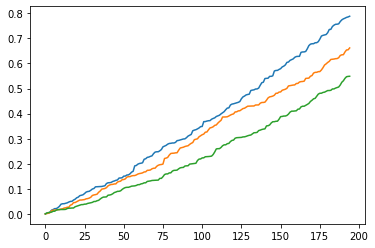

In [240]:
femdatest = FEMDA()
femdatest.fit(X3, pd.Series(y3))
#print_metrics(pd.Series(y_test), t_qdatest.predict(X_test, percent_outliers))

In [241]:
print_metrics(pd.Series(y3_test_clean), femdatest.predict(X3_test), conf=True)

hello
[  10.77149402    9.41805746   94.61749881 ... 3253.22212793    4.94806845
   87.89744911]
[ 294.04722027  186.41555397   84.71691345 ... 1361.14348814  293.79658342
   65.24314159]
[1.22779681e+02 5.16475984e+01 1.71939220e+01 ... 2.21103101e+03
 1.35357011e+02 1.45951432e-01]
N 1500 Accuracy 0.88133 ARI 0.66637 AMI 0.68169
[[413   0  87]
 [  0 416  84]
 [  5   2 493]]


In [242]:
print_metrics(pd.Series(y3_test_clean), FEM_predictor(3).predict(X3_test, femdatest.means, femdatest.covariances), conf=True)

N 1500 Accuracy 0.934 ARI 0.81197 AMI 0.74065
[[473  14  13]
 [ 12 457  31]
 [ 14  15 471]]


With outlier rejection
LDA
N 1500 Accuracy 0.89133 ARI 0.75724 AMI 0.66452
QDA
N 1500 Accuracy 0.89267 ARI 0.75891 AMI 0.66608
t-LDA
N 1500 Accuracy 0.892 ARI 0.75625 AMI 0.66007
t-QDA
N 1500 Accuracy 0.89467 ARI 0.75788 AMI 0.66213
t-QDA-FEM
maha avg 2.025692134623495
maha avg 1.8865649244597371
maha avg 1.5791601915976679
N 1500 Accuracy 0.896 ARI 0.7604 AMI 0.66575
QDA-FEM
maha avg 2.025692134623495
maha avg 1.8865649244597371
maha avg 1.5791601915976679
N 1500 Accuracy 0.88867 ARI 0.74965 AMI 0.65579


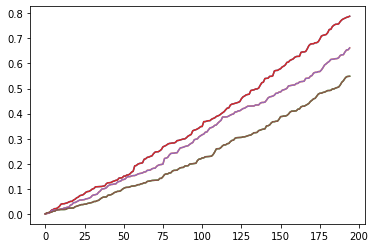

In [243]:
print("With outlier rejection")
models_synth3 = run_all(X3,y3,X3_test,y3_test, percent_outliers=0.05)

In [248]:
models_synth3["FEMDA"] = femdatest

hello
[1567.90157367 1499.32339475 1434.42734081 ... 3267.97964904 3365.82947602
 3467.36142798]
[2259.01401674 2179.90327347 2109.23834339 ...  925.53113885  967.99183165
 1018.89833765]
[2423.61537565 2323.82446875 2230.06099468 ... 2217.63294552 2312.11022803
 2412.61494336]
hello
[  10.77149402    9.41805746   94.61749881 ... 3253.22212793    4.94806845
   87.89744911]
[ 294.04722027  186.41555397   84.71691345 ... 1361.14348814  293.79658342
   65.24314159]
[1.22779681e+02 5.16475984e+01 1.71939220e+01 ... 2.21103101e+03
 1.35357011e+02 1.45951432e-01]


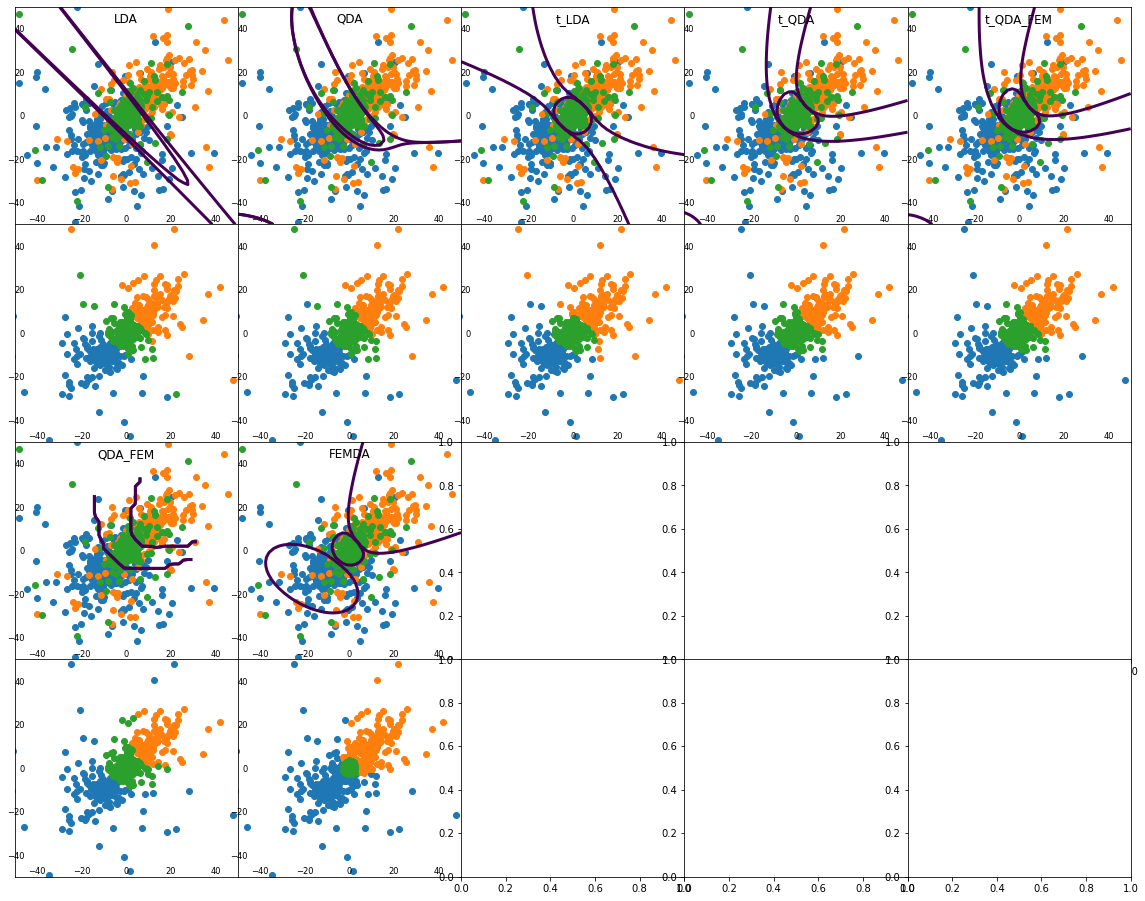

In [249]:
plot_models(X3, y3, X3_test, models_synth3, percent_outliers=0, lims=[[-50,50],[-50,50]])

In [244]:
evaluate_all(models_synth3[2:], means_synth3, covs_synth3)

TypeError: unhashable type: 'slice'

In [246]:
print("Without outlier rejection")
test_all(list(models_synth3.values()), X3_test, y3_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 1500 Accuracy 0.938 ARI 0.82283 AMI 0.75489
QDA
N 1500 Accuracy 0.93867 ARI 0.82465 AMI 0.75775
t_LDA
N 1500 Accuracy 0.93867 ARI 0.8248 AMI 0.75465
t_QDA
N 1500 Accuracy 0.94067 ARI 0.82999 AMI 0.76205
t_QDA_FEM
N 1500 Accuracy 0.942 ARI 0.83364 AMI 0.7658
QDA_FEM
N 1500 Accuracy 0.93867 ARI 0.82442 AMI 0.75954


### Normalised dataset with test contamination

In [214]:
X3_n = normalise_centered(X3, y3)
X3_test_n = normalise_centered(X3_test, y3_test_clean)

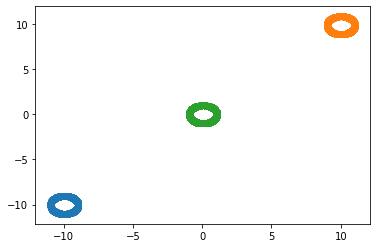

In [215]:
_,ax = plt.subplots()
plot_dataset(X3_n, y3, ax)

(array([ 0.01026197, -0.04561915]),
 array([[ 0.50925966, -0.00784129],
        [-0.00784129,  0.48855393]]),
 array([400.99144916]))

In [217]:
print("With outlier rejection")
models_synth3_n = run_all(X3_n,y3,X3_test,y3_test, percent_outliers=0.05)

With outlier rejection
LDA
N 1500 Accuracy 0.89333 ARI 0.77212 AMI 0.68688
QDA
N 1500 Accuracy 0.89467 ARI 0.77379 AMI 0.68802
t-LDA
N 1500 Accuracy 0.89333 ARI 0.7722 AMI 0.68709
t-QDA
N 1500 Accuracy 0.89467 ARI 0.77384 AMI 0.68813
t-QDA-FEM
N 1500 Accuracy 0.89533 ARI 0.77376 AMI 0.68565
QDA-FEM
N 1500 Accuracy 0.89267 ARI 0.7727 AMI 0.68952


In [228]:
models_synth3_n[0].means

array([[ -9.93673965,  10.01612719,   0.0671715 ],
       [-10.03451608,   9.9038193 ,   0.01264676]])

[[ -9.93673965 -10.03451608]
 [ 10.01612719   9.9038193 ]
 [  0.0671715    0.01264676]] [array([-10., -10.]), array([10., 10.]), array([0., 0.])]
[array([-10., -10.]), array([10., 10.]), array([0., 0.])] [[ -9.93673965 -10.03451608]
 [ 10.01612719   9.9038193 ]
 [  0.0671715    0.01264676]]
[[ -9.93673965 -10.03451608]
 [ 10.01612719   9.9038193 ]
 [  0.0671715    0.01264676]] [array([-10., -10.]), array([10., 10.]), array([0., 0.])]
[array([-10., -10.]), array([10., 10.]), array([0., 0.])] [[ -9.93673965 -10.03451608]
 [ 10.01612719   9.9038193 ]
 [  0.0671715    0.01264676]]
[[ -9.93668842 -10.03448294]
 [ 10.01614202   9.90383319]
 [  0.06719935   0.01264299]] [array([-10., -10.]), array([10., 10.]), array([0., 0.])]
[array([-10., -10.]), array([10., 10.]), array([0., 0.])] [[ -9.93668842 -10.03448294]
 [ 10.01614202   9.90383319]
 [  0.06719935   0.01264299]]
[[ -9.93668842 -10.03448294]
 [ 10.01614202   9.90383319]
 [  0.06719935   0.01264299]] [array([-10., -10.]), array([10., 10

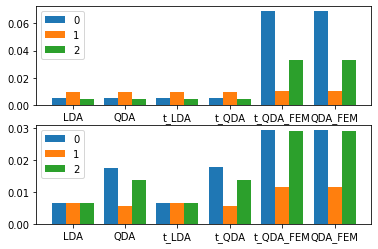

In [227]:
evaluate_all(models_synth3_n[0:], means_synth3, covs_synth3)

In [230]:
print("Without outlier rejection")
test_all(models_synth3_n, X3_test, y3_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 1500 Accuracy 0.94467 ARI 0.84035 AMI 0.77621
QDA
N 1500 Accuracy 0.946 ARI 0.8441 AMI 0.78005
t_LDA
N 1500 Accuracy 0.946 ARI 0.84405 AMI 0.78133
t_QDA
N 1500 Accuracy 0.94733 ARI 0.84781 AMI 0.78517
t_QDA_FEM
N 1500 Accuracy 0.94467 ARI 0.84051 AMI 0.77386
QDA_FEM
N 1500 Accuracy 0.94333 ARI 0.83678 AMI 0.77061


## Synthetic data setup 4

In [54]:
p=30
means_synth4 = dict((k,v) for k,v in enumerate(models_MNIST_pure["t_QDA"].means.T))
covs_synth4 = dict((k,v) for k,v in enumerate(models_MNIST_pure["t_QDA"].covariances))

In [79]:
def synthesise4(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    def mixture(n_k, mean, cov, mix=0.3, kappa=0.2, df=20):
        Xa = LaplacesDemon.rmvpe(n_k, mu=mean, Sigma=cov, kappa=kappa) #Generalised Gaussian
        oa = np.zeros((n_k))>0
        Xb,ob = contaminated(n_k, stats.multivariate_t, contamination, loc=mean, shape=cov, df=df, hard=hard) # Gaussian
        X = combine_dataset(Xa,Xb,mix)
        o = combine_dataset(oa, ob,mix)
        return X,o
    
    X1,o1 = mixture(n, means_synth4[0], covs_synth4[0], mix=0.8, kappa=0.2, df=20)
    X2,o2 = mixture(n, means_synth4[1], covs_synth4[1], mix=0.8, kappa=0.2, df=20)
    X3,o3 = mixture(n, means_synth4[2], covs_synth4[2], mix=0.8, kappa=0.2, df=20)
    X4,o4 = mixture(n, means_synth4[3], covs_synth4[3], mix=0.8, kappa=0.2, df=20)
    X5,o5 = mixture(n, means_synth4[4], covs_synth4[4], mix=0.8, kappa=0.2, df=20)
    
    y = mislabelled(n, mislabelling, np.arange(5))
    #print(y)
    return np.vstack([X1, X2, X3, X4, X5]), y, apply_outlierness([o1,o2,o3,o4,o5], y)

In [80]:
X4,y4,_ = synthesise4(1000, contamination=0.1, mislabelling=0) #don't know outliers

In [81]:
X4_test,y4_test_clean,y4_test = synthesise4(500, contamination=0.05) #compare with known outliers

With outlier rejection
LDA
0.015620231628417969
N 2500 Accuracy 0.2944 ARI 0.00955 AMI 0.04635
QDA
0.015629053115844727
N 2500 Accuracy 0.7576 ARI 0.50901 AMI 0.58972
t-LDA
3.8259341716766357
N 2500 Accuracy 0.294 ARI 0.02925 AMI 0.11681
t-QDA
3.8106932640075684
N 2500 Accuracy 0.8916 ARI 0.79518 AMI 0.75439
t-QDA-FEM
maha avg 3360889145288.6074
maha avg 4388460205438.6357
maha avg 2756526372385.7803
maha avg 3659178719760.76
maha avg 4088595852323.498
0.3541569709777832
N 2500 Accuracy 0.7632 ARI 0.51806 AMI 0.6001
QDA-FEM
maha avg 3360889145288.6074
maha avg 4388460205438.6357
maha avg 2756526372385.7803
maha avg 3659178719760.76
maha avg 4088595852323.498
0.33858442306518555
N 2500 Accuracy 0.7596 ARI 0.51243 AMI 0.59133


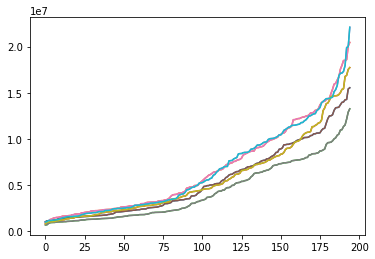

In [279]:
print("With outlier rejection")
models_synth4 = run_all(X4,y4,X4_test,y4_test, percent_outliers=0.05)

In [105]:
for c in models_synth4["t_QDA"].covariances:
    print(np.trace(c))

20349129.654235076
24747385.210484426
15560209.293971747
20712496.732398245
23768826.47634433


In [83]:
print("Without outlier rejection")
test_all(list(models_synth4.values()),X4_test,y4_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
QDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
t_LDA
N 2500 Accuracy 0.3048 ARI 0.0092 AMI 0.10542
t_QDA
N 2500 Accuracy 0.9632 ARI 0.91146 AMI 0.89214
t_QDA_FEM
N 2500 Accuracy 0.8112 ARI 0.5511 AMI 0.63693
QDA_FEM
N 2500 Accuracy 0.8088 ARI 0.5469 AMI 0.62944


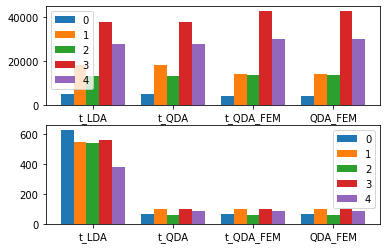

In [84]:
evaluate_all(list(models_synth4.values())[2:], means_synth4, covs_synth4)

maha avg 3360889145288.6074
maha avg 4388460205438.6357
maha avg 2756526372385.7803
maha avg 3659178719760.76
maha avg 4088595852323.498


[array([[ 2.71188441e+05,  8.82145419e+03, -4.32879874e+05, ...,
         -7.72246341e+04,  6.27557206e+04, -1.24203446e+05],
        [-1.43173692e+06,  8.97806160e+05, -6.98254459e+05, ...,
         -6.55210556e+04, -2.22436557e+05,  1.28872351e+05],
        [-2.06144177e+06,  2.07740566e+06, -8.01613297e+05, ...,
         -4.18440673e+05, -3.20633365e+05,  3.85320096e+05],
        ...,
        [ 2.71430233e+03, -2.79070276e+03,  1.44922035e+03, ...,
          4.23071781e+02,  7.44840487e+00, -9.20658467e+01],
        [-1.49727448e+03, -1.95858315e+02,  8.09080353e+02, ...,
          1.09675999e+02,  9.94792615e+01, -3.35859714e+01],
        [ 5.65989371e+02, -9.50896717e+02,  9.52373021e+02, ...,
         -2.67469119e+02, -8.75520310e+00,  5.04153553e+01]]),
 array([[ 2.24190885e+06, -5.75911526e+05, -4.46195805e+05, ...,
          1.22953996e+05,  1.53157517e+05, -1.47202772e+05],
        [ 2.50191315e+06, -1.31819130e+06, -2.36249443e+05, ...,
         -2.54900673e+05, -9.09627757e

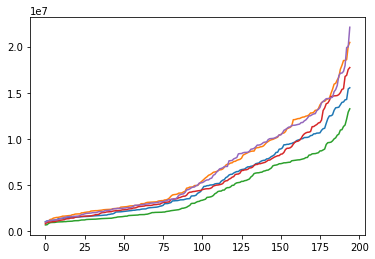

In [201]:
femdatest = FEMDA()
femdatest.fit(X4, pd.Series(y4))

In [202]:
print_metrics(pd.Series(y4_test_clean), femdatest.predict(X4_test), conf=True)

hello
[3.94198405e-01 1.04414041e+00 8.97614268e-01 ... 8.06889855e-06
 9.21339824e-06 2.96666887e-05]
[6.28867712e-01 1.63149794e+00 8.42124279e-01 ... 6.83587086e-06
 2.07983819e-06 1.16853770e-05]
[7.09365542e+00 5.50697219e+00 2.62078507e+00 ... 2.68367858e-05
 3.44781157e-05 1.14009245e-04]
N 2500 Accuracy 0.5984 ARI 0.46643 AMI 0.68238
[[497   3   0   0   0]
 [  0 500   0   0   0]
 [  0   1 499   0   0]
 [  0 500   0   0   0]
 [ 76 424   0   0   0]]


# What is this behaviour? ^

In [256]:
X4_n = normalise_centered(X4, y4)
X4_test_n = normalise_centered(X4_test, y4_test_clean)

With outlier rejection
LDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
QDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
t-LDA
N 2500 Accuracy 0.2252 ARI 0.00084 AMI 0.02933
t-QDA
N 2500 Accuracy 0.5576 ARI 0.2851 AMI 0.42409
t-QDA-FEM
maha avg 1.1662823152025363
maha avg 1.1206252224426207
maha avg 1.0225556851366358
maha avg 1.0424626876224905
maha avg 1.0981150101789714
N 2500 Accuracy 0.6116 ARI 0.34797 AMI 0.47494
QDA-FEM
maha avg 1.1662823152025363
maha avg 1.1206252224426207
maha avg 1.0225556851366358
maha avg 1.0424626876224905
maha avg 1.0981150101789714
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0


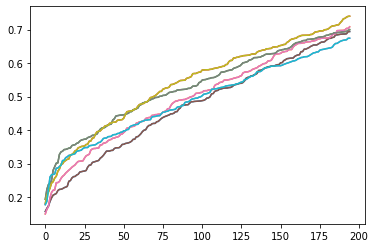

In [259]:
print("With outlier rejection")
models_synth4_n = run_all(X4_n,y4,X4_test,y4_test_clean, percent_outliers=0)

maha avg 1.1662823152025363
maha avg 1.1206252224426207
maha avg 1.0225556851366358
maha avg 1.0424626876224905
maha avg 1.0981150101789714


[array([[-371.21458537, -467.58012743,  642.41257469, ...,   35.71291044,
           19.01708977,   10.31914637],
        [-372.21871082, -467.13318704,  642.49943877, ...,   35.75836738,
           18.84010124,   10.51125553],
        [-372.08709709, -466.98908218,  642.62269074, ...,   35.67073494,
           18.86046023,   10.55713748],
        ...,
        [-370.76960692, -468.13302173,  643.04317225, ...,   35.88226947,
           18.9504391 ,   10.42180156],
        [-372.09338553, -467.44430486,  642.94342629, ...,   35.83118203,
           18.996187  ,   10.4222377 ],
        [-370.95555392, -467.86586615,  643.03147396, ...,   35.61832632,
           18.93729162,   10.46862861]]),
 array([[393.84495058, 660.57760222, -52.74618458, ...,  12.10647084,
           6.5658762 , -11.27897078],
        [393.9066438 , 660.33727214, -52.67149207, ...,  11.97953982,
           6.48305707, -11.27811864],
        [392.65743697, 660.32717947, -52.35386015, ...,  12.1122639 ,
           6.62

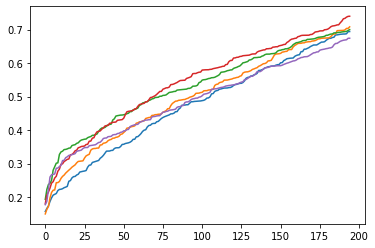

In [262]:
femdatest = FEMDA()
femdatest.fit(X4_n, pd.Series(y4))

In [263]:
print_metrics(pd.Series(y4_test_clean), femdatest.predict(X4_test_n), conf=True)

hello
[  44625.27301931   44598.98830291   44558.22623004 ... 1038269.76668389
 1036339.13316012 1040030.58700544]
[5335199.00732788 5333564.52767683 5342168.10693771 ...  509579.31022877
  508298.74332485  508521.2930476 ]
[26633330.43447399 26665063.60592341 26675719.67375409 ...
  2082302.52561025  2073253.33044421  2084360.70852634]
N 2500 Accuracy 0.6 ARI 0.48236 AMI 0.74216
[[500   0   0   0   0]
 [  0 500   0   0   0]
 [  0   0 500   0   0]
 [  0 500   0   0   0]
 [  0 500   0   0   0]]


## Statlog test

### Prepare Statlog data

In [68]:
read_statlog = pd.read_csv(r"data\statlog.csv")
statlog_labels = read_statlog.iloc[:, 0]
statlog_data = read_statlog.iloc[:, 1:]

In [69]:
# train test split
statlog_train, statlog_test, statlog_labels, statlog_test_labels = train_test_split(statlog_data, statlog_labels, test_size=0.33, random_state=42)
statlog_train = np.array(statlog_train); statlog_test = np.array(statlog_test); statlog_labels = np.array(statlog_labels); statlog_test_labels = np.array(statlog_test_labels); 

In [83]:
statlog_test.shape

(228, 5)

### Pure Statlog

In [70]:
models_statlog_pure = run_all(statlog_train, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.71053 ARI 0.17144 AMI 0.11268
QDA
N 228 Accuracy 0.69737 ARI 0.14257 AMI 0.11038
t-LDA
N 228 Accuracy 0.64912 ARI 0.08505 AMI 0.06629
t-QDA
N 228 Accuracy 0.74561 ARI 0.23714 AMI 0.16617
RGQDA
optimal c is 0.09106056204551535
N 228 Accuracy 0.63596 ARI 0.0669 AMI 0.1037
RGQDA-S
optimal c is 0.0
N 228 Accuracy 0.60965 ARI 0.04331 AMI 0.0464
RQDA-M
N 228 Accuracy 0.72807 ARI 0.20217 AMI 0.1367
RQDA-S
N 228 Accuracy 0.62281 ARI 0.05631 AMI 0.04244
t-QDA-FEM
N 185 Accuracy 0.75135 ARI 0.23979 AMI 0.14918
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with mislabelling

In [71]:
statlog_labels_mislabelled = flip_bits(statlog_labels, 0.1)

In [72]:
models_statlog_mislabelling = run_all(statlog_train, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.70175 ARI 0.15762 AMI 0.10315
QDA
N 228 Accuracy 0.67544 ARI 0.10723 AMI 0.08366
t-LDA
N 228 Accuracy 0.64035 ARI 0.07475 AMI 0.06327
t-QDA
N 228 Accuracy 0.74123 ARI 0.22923 AMI 0.16744
RGQDA
optimal c is 0.05558424384035826
N 228 Accuracy 0.60526 ARI 0.03535 AMI 0.08349
RGQDA-S
optimal c is 0.6508156979525312
N 228 Accuracy 0.62719 ARI 0.06071 AMI 0.04649
RQDA-M
N 228 Accuracy 0.73684 ARI 0.21834 AMI 0.15002
RQDA-S
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
t-QDA-FEM
N 188 Accuracy 0.74468 ARI 0.22391 AMI 0.1345
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with contamination

In [73]:
statlog_train_contaminated = contaminate_dataset(statlog_train, 0.1)

In [74]:
models_statlog_contaminated = run_all(statlog_train_contaminated, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.58333 ARI 0.00254 AMI -0.00428
t-LDA
N 228 Accuracy 0.65789 ARI 0.09496 AMI 0.099
t-QDA
N 228 Accuracy 0.72807 ARI 0.20459 AMI 0.15293
RGQDA
optimal c is 0.0
N 228 Accuracy 0.65351 ARI 0.08797 AMI 0.11901
RGQDA-S
optimal c is 0.6243759205910031
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RQDA-M
N 228 Accuracy 0.7193 ARI 0.18479 AMI 0.12568
RQDA-S
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t-QDA-FEM
N 186 Accuracy 0.74731 ARI 0.2263 AMI 0.1338
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with contamination and mislabelling

In [75]:
models_statlog_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.58333 ARI 0.00254 AMI -0.00428
t-LDA
N 228 Accuracy 0.65789 ARI 0.09496 AMI 0.099
t-QDA
N 228 Accuracy 0.72807 ARI 0.20459 AMI 0.15293
RGQDA
optimal c is 0.0
N 228 Accuracy 0.65351 ARI 0.08797 AMI 0.11901
RGQDA-S
optimal c is 0.6243781560312783
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RQDA-M
N 228 Accuracy 0.7193 ARI 0.18479 AMI 0.12568
RQDA-S
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t-QDA-FEM
N 186 Accuracy 0.74731 ARI 0.2263 AMI 0.1338
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with test contamination

In [76]:
test_all(models_statlog_contaminated_mislabelling, contaminate_dataset(statlog_test, 0.1), statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.57018 ARI 0.00121 AMI -0.00376
t_LDA
N 228 Accuracy 0.64035 ARI 0.0748 AMI 0.06151
t_QDA
N 228 Accuracy 0.71491 ARI 0.18099 AMI 0.12966
RGQDA
N 228 Accuracy 0.62719 ARI 0.05726 AMI 0.09639
RGQDA
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RGQDA
N 228 Accuracy 0.71053 ARI 0.17144 AMI 0.11268
RGQDA
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t_QDA_FEM
N 211 Accuracy 0.67773 ARI 0.11323 AMI 0.06829
QDA_FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


## NORB test

### Prepare NORB data

In [85]:
from smallnorb import *

In [86]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 1553516.96it/s]


In [87]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

In [88]:
# train test split
NORB_train, NORB_test, NORB_labels, NORB_test_labels = train_test_split(NORB_pca, NORB_labels_sel, test_size=0.33, random_state=42)
NORB_train = np.array(NORB_train); NORB_test = np.array(NORB_test); NORB_labels = np.array(NORB_labels); NORB_test_labels = np.array(NORB_test_labels); 

In [ ]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

In [ ]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Pure NORB test

In [91]:
models_NORB_pure = run_all(NORB_train, NORB_labels, NORB_test, NORB_test_labels)

LDA
N 528 Accuracy 0.80114 ARI 0.56072 AMI 0.55591
QDA
N 528 Accuracy 0.9072 ARI 0.78209 AMI 0.75595
t-LDA
N 528 Accuracy 0.78788 ARI 0.54133 AMI 0.52902
t-QDA
N 528 Accuracy 0.91667 ARI 0.80098 AMI 0.76927
RGQDA
optimal c is 0.38268400076152365
N 528 Accuracy 0.90341 ARI 0.75874 AMI 0.74269
RGQDA-S
optimal c is 0.5576732772084341
N 528 Accuracy 0.89773 ARI 0.75373 AMI 0.73538
RQDA-M
N 528 Accuracy 0.90341 ARI 0.77156 AMI 0.74482
RQDA-S
N 528 Accuracy 0.89394 ARI 0.74881 AMI 0.72375
t-QDA-FEM
N 313 Accuracy 0.92013 ARI 0.79482 AMI 0.77751
QDA-FEM
N 62 Accuracy 1.0 ARI 1.0 AMI 1.0


In [ ]:
models_NORB_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

In [ ]:
for c in np.linspace(0.01,1,100):
    test_gqda.c = c
    accuracies += [acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))]

In [ ]:
test_gqda.c = 1
test_gqda.fudge = 0
acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))

In [ ]:
plt.scatter(X[:,0],X[:,1])
plot_contours(X, test_gqda.predict_proba, plt.gca())

In [81]:
import dill

In [82]:
dill.dump_session('notebook_env.db')

NotImplementedError: Sorry, pickling not yet supported. See https://github.com/pydata/patsy/issues/26 if you want to help.